In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandasql import sqldf

In [29]:
pysqldf = lambda q: sqldf(q, globals())
%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format

In [30]:
columns = ['customer_id', 'purchase_amount', 'date_of_purchase']
df = pd.read_csv('purchases.txt', header=None, sep='\t',
            names=columns)
df.sample(n=5, random_state=57)

,customer_id,purchase_amount,date_of_purchase
4510,8060,30.00,2014-12-24
17761,109180,50.00,2009-11-25
39110,9830,30.00,2007-06-12
37183,56400,60.00,2009-09-30
33705,41290,60.00,2007-08-21


In [31]:
# interpret the last column as datetime
df['date_of_purchase'] = pd.to_datetime(df['date_of_purchase'], 
                                        format='%Y-%m-%d')
# Extract year of purchase and save it as a column
df['year_of_purchase'] = df['date_of_purchase'].dt.year
df.head()

,customer_id,purchase_amount,date_of_purchase,year_of_purchase
0,760,25.00,2009-11-06,2009
1,860,50.00,2012-09-28,2012
2,1200,100.00,2005-10-25,2005
3,1420,50.00,2009-07-09,2009
4,1940,70.00,2013-01-25,2013


In [32]:
# Add a day_since column showing the difference between last purchase and a basedate
basedate = pd.Timestamp('2016-01-01')
df['days_since'] = (basedate - df['date_of_purchase']).dt.days

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51243 entries, 0 to 51242
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       51243 non-null  int64         
 1   purchase_amount   51243 non-null  float64       
 2   date_of_purchase  51243 non-null  datetime64[ns]
 3   year_of_purchase  51243 non-null  int64         
 4   days_since        51243 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 2.0 MB


In [34]:
# Compute recency, frequency, and average purchase amount
q = """
        SELECT customer_id,
        MIN(days_since) AS 'recency',
        MAX(days_since) AS 'first_purchase',
        COUNT(*) AS 'frequency',
        AVG(purchase_amount) AS 'amount'
        FROM df GROUP BY 1"""
customers_2015 = sqldf(q)

In [35]:
customers_2015.head()

,customer_id,recency,first_purchase,frequency,amount
0,10,3829,3829,1,30.00
1,80,343,3751,7,71.43
2,90,758,3783,10,115.80
3,120,1401,1401,1,20.00
4,130,2970,3710,2,50.00


In [36]:
customers_2015.describe()

,customer_id,recency,first_purchase,frequency,amount
count,"18,417.00","18,417.00","18,417.00","18,417.00","18,417.00"
mean,"137,573.51","1,253.04","1,984.01",2.78,57.79
std,"69,504.60","1,081.44","1,133.41",2.94,154.36
min,10.00,1.00,1.00,1.00,5.00
25%,"81,990.00",244.00,988.00,1.00,21.67
50%,"136,430.00","1,070.00","2,087.00",2.00,30.00
75%,"195,100.00","2,130.00","2,992.00",3.00,50.00
max,"264,200.00","4,014.00","4,016.00",45.00,"4,500.00"


In [41]:
customers_2015.iloc[:,2:].head()

,first_purchase,frequency,amount
0,3829,1,30.00
1,3751,7,71.43
2,3783,10,115.80
3,1401,1,20.00
4,3710,2,50.00


array([[<AxesSubplot:title={'center':'recency'}>,
        <AxesSubplot:title={'center':'first_purchase'}>],
       [<AxesSubplot:title={'center':'frequency'}>,
        <AxesSubplot:title={'center':'amount'}>]], dtype=object)

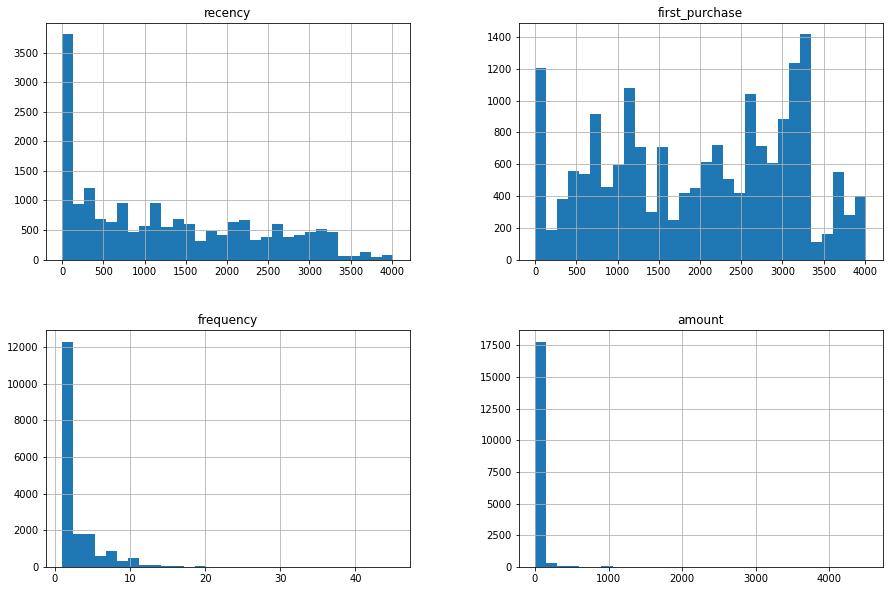

In [42]:
customers_2015.iloc[:,1:].hist(bins=30, figsize=(15, 10))

# Coding a Managerial Segmentation

In [43]:
customers_2015.loc[customers_2015['recency'] > 365*3, 'segment'] = 'inactive'
customers_2015.head()

,customer_id,recency,first_purchase,frequency,amount,segments
0,10,3829,3829,1,30.00,inactive
1,80,343,3751,7,71.43,NaN
2,90,758,3783,10,115.80,NaN
3,120,1401,1401,1,20.00,inactive
4,130,2970,3710,2,50.00,inactive


## Simple 2-segment solution based on recency alone

In [44]:
#customers_2015.rename(columns={'segments': 'segment'}, inplace=True)
customers_2015['segment'] =  customers_2015['segment'].fillna('NA')

In [45]:
customers_2015['segment'].value_counts()

NA          9259
inactive    9158
Name: segment, dtype: int64

In [46]:
two_seg = customers_2015[['recency', 'frequency', 'amount', 'segment']].groupby('segment').mean()

In [47]:
two_seg.head().T

segment,NA,inactive
recency,338.06,"2,178.11"
frequency,3.74,1.81
amount,67.37,48.11


## A more complex 3-segment solution based on recency alone


In [48]:
customers_2015.loc[(customers_2015['recency']<= 365*3) & 
                   (customers_2015['recency'] > 356*2), 'segment'] = "cold"
customers_2015['segment'].value_counts()

inactive    9158
NA          7354
cold        1905
Name: segment, dtype: int64

In [49]:
three_seg = customers_2015[['recency', 'frequency', 'amount', 'segment']].groupby('segment').mean()
three_seg.head().T

segment,NA,cold,inactive
recency,203.46,857.63,"2,178.11"
frequency,4.11,2.30,1.81
amount,71.42,51.72,48.11


## A more complex 4-segment solution

In [50]:
customers_2015.loc[(customers_2015['recency']<= 365*2) & 
                   (customers_2015['recency'] > 365*1), 'segment'] = "warm"
customers_2015.loc[customers_2015['recency']<= 365, 'segment'] = "active"
customers_2015['segment'].value_counts()

inactive    9158
active      5398
warm        1958
cold        1903
Name: segment, dtype: int64

In [51]:
# Further segmentation of the warm segment:
customers_2015.loc[(customers_2015['segment'] == "warm") &
                  (customers_2015['first_purchase'] <= 365*2), 'segment'] = "new warm"

customers_2015.loc[(customers_2015['segment'] == "warm") &
                  (customers_2015['amount'] < 100), 'segment'] = "warm low value"

customers_2015.loc[(customers_2015['segment'] == "warm") &
                  (customers_2015['amount'] >= 100), 'segment'] = "warm high value"
customers_2015['segment'].value_counts()

inactive           9158
active             5398
cold               1903
new warm            938
warm low value      901
warm high value     119
Name: segment, dtype: int64

In [52]:
# Further segmentation of the active segment:
customers_2015.loc[(customers_2015['segment'] == "active") &
                  (customers_2015['first_purchase'] <= 365), 'segment'] = "new active"

customers_2015.loc[(customers_2015['segment'] == "active") &
                  (customers_2015['amount'] < 100), 'segment'] = "active low value"

customers_2015.loc[(customers_2015['segment'] == "active") &
                  (customers_2015['amount'] >= 100), 'segment'] = "active high value"
customers_2015['segment'].value_counts()

inactive             9158
active low value     3313
cold                 1903
new active           1512
new warm              938
warm low value        901
active high value     573
warm high value       119
Name: segment, dtype: int64

In [65]:
customers_2015.iloc[:,1:].describe()

,recency,first_purchase,frequency,amount
count,"18,417.00","18,417.00","18,417.00","18,417.00"
mean,"1,253.04","1,984.01",2.78,57.79
std,"1,081.44","1,133.41",2.94,154.36
min,1.00,1.00,1.00,5.00
25%,244.00,988.00,1.00,21.67
50%,"1,070.00","2,087.00",2.00,30.00
75%,"2,130.00","2,992.00",3.00,50.00
max,"4,014.00","4,016.00",45.00,"4,500.00"


In [58]:
# Re-order factor in a way that makes sense
customers_2015['segment'] = customers_2015['segment'].astype('category')
customers_2015.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18417 entries, 0 to 18416
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   customer_id     18417 non-null  int64   
 1   recency         18417 non-null  int64   
 2   first_purchase  18417 non-null  int64   
 3   frequency       18417 non-null  int64   
 4   amount          18417 non-null  float64 
 5   segment         18417 non-null  category
 6   segment_sort    18417 non-null  category
dtypes: category(2), float64(1), int64(4)
memory usage: 756.2 KB


In [59]:

customers_2015['segment_sort'] = pd.Categorical( customers_2015['segment'],
        categories=['inactive', 'cold', 'warm high value','warm low value', 
           'new warm', 'active high value', 'active low value',
           'new active'], ordered=True)
customers_2015.head()

,customer_id,recency,first_purchase,frequency,amount,segment,segment_sort
0,10,3829,3829,1,30.00,inactive,inactive
1,80,343,3751,7,71.43,active low value,active low value
2,90,758,3783,10,115.80,cold,cold
3,120,1401,1401,1,20.00,inactive,inactive
4,130,2970,3710,2,50.00,inactive,inactive


In [60]:
customers_2015.sort_values('segment_sort')

,customer_id,recency,first_purchase,frequency,amount,segment,segment_sort
0,10,3829,3829,1,30.00,inactive,inactive
7894,119690,1500,2443,4,30.00,inactive,inactive
7895,119710,2249,2443,3,26.67,inactive,inactive
7896,119720,2156,2443,2,40.00,inactive,inactive
7897,119730,2443,2443,1,50.00,inactive,inactive
...,...,...,...,...,...,...,...
17404,252380,73,73,1,10.00,new active,new active
17403,252370,73,73,1,45.00,new active,new active
17402,252360,73,73,1,20.00,new active,new active
17411,252450,72,72,1,45.00,new active,new active
